In [1]:
import cv2
import os

import keras.losses

os.environ["SM_FRAMEWORK"] = "tf.keras"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
n_classes = 6
seed = 24
batch_size = 8
epochs = 50
learning_rate = 1e-3
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
input_shape = (256, 256, 3)
model_file = '../models/vgg16_unet_transfer_learning_model.keras'
train_image_path = "../dataset/256_patches_splitted_RF/train/images"
train_mask_path = "../dataset/256_patches_splitted_RF/train/masks"
val_image_path = "../dataset/256_patches_splitted_RF/val/images"
val_mask_path = "../dataset/256_patches_splitted_RF/val/masks"
test_image_path = "../dataset/256_patches_splitted_RF/test/images"
test_mask_path = "../dataset/256_patches_splitted_RF/test/masks"
color_map = {
    0: [0, 0, 0],  # Background (unlabeled - black)
    1: [255, 0, 0],  # Class 1 (building - #FF0000)
    2: [255, 105, 180],  # Class 2 (water - #FF69B4 )
    3: [65, 117, 5],  # Class 3 (tree - #417505)
    4: [126, 211, 33],  # Class 4 (grass - #7ED321)
    5: [169, 169, 169],  # Class 5 (road - #A9A9A9)
    6: [139, 87, 42]  # Class 6 (soil - #8B572A)
}

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


# BACKBONE = 'vgg16'
# preprocess_input = sm.get_preprocessing(BACKBONE)

from tensorflow.keras.applications.vgg16 import VGG16

base_vgg16 = VGG16(include_top=False,
                   weights="imagenet",
                   input_shape=input_shape)
base_vgg16.summary()


def TL_unet_model(input_shape, num_classes):
    # input: input_shape (height, width, channels) 
    # return model

    # the bridge (exclude the last maxpooling layer in VGG-16) 
    bridge = base_vgg16.get_layer("block5_conv3").output

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), kernel_initializer='he_normal', strides=(2, 2), padding='same')(bridge)
    concat_1 = concatenate([up1, base_vgg16.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(conv6)
    concat_2 = concatenate([up2, base_vgg16.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(conv7)
    concat_3 = concatenate([up3, base_vgg16.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(conv8)
    concat_4 = concatenate([up4, base_vgg16.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model_ = Model(inputs=[base_vgg16.input], outputs=[conv10])

    return model_

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [4]:
def get_items(directory_path, type):
    image_dataset = []
    for subfile in os.listdir(directory_path):
        image = cv2.imread(directory_path + '/' + subfile)
        if type == "image":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_dataset.append(image)
    image_dataset = np.array(image_dataset)
    return image_dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# from tensorflow.keras.applications.vgg16 import preprocess_input
label_encoder = LabelEncoder()
scaler = MinMaxScaler()
X_train = get_items(train_image_path, "image")
X_val = get_items(val_image_path, "image")
X_test = get_items(test_image_path, "image")
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)
# X_test = preprocess_input(X_test)
print("X_train: %s , X_val: %s , X_test: %s" % (X_train.shape, X_val.shape, X_test.shape))
Y_train = get_items(train_mask_path, "mask")
Y_val = get_items(val_mask_path, "mask")
Y_test = get_items(test_mask_path, "mask")
Y_train = label_encoder.fit_transform(np.ravel(Y_train)).reshape(Y_train.shape)
Y_test = label_encoder.fit_transform(np.ravel(Y_test)).reshape(Y_test.shape)
Y_val = label_encoder.fit_transform(np.ravel(Y_val)).reshape(Y_val.shape)
print("Y_train: %s , Y_val: %s , Y_test: %s" % (Y_train.shape, Y_val.shape, Y_test.shape))
print(np.unique(Y_train))

X_train: (72, 256, 256, 3) , X_val: (24, 256, 256, 3) , X_test: (24, 256, 256, 3)
Y_train: (72, 256, 256) , Y_val: (24, 256, 256) , Y_test: (24, 256, 256)
[0 1 2 3 4 5]


In [6]:
from keras.utils import to_categorical

Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
Y_val_cat = to_categorical(Y_val, num_classes=n_classes)
Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
print("Y_train_cat: %s , Y_val_cat: %s , Y_test_cat: %s" % (Y_train_cat.shape, Y_val_cat.shape, Y_test_cat.shape))

Y_train_cat: (72, 256, 256, 6) , Y_val_cat: (24, 256, 256, 6) , Y_test_cat: (24, 256, 256, 6)


In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')
datagen2 = ImageDataGenerator()
train_gen = datagen.flow(X_train, Y_train_cat, batch_size=batch_size, shuffle=True, seed=seed)
val_gen = datagen2.flow(X_val, Y_val_cat, batch_size=batch_size, shuffle=False, seed=seed)
test_gen = datagen2.flow(X_test, Y_test_cat, batch_size=batch_size, shuffle=False, seed=seed)

In [8]:
metrics = ['accuracy', jacard_coef]
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [9]:
# weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# import segmentation_models as sm
# 
# dice_loss = sm.losses.DiceLoss(class_weights=weights)
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

In [10]:
# freezing all layers in VGG16

for layer in base_vgg16.layers:
    layer.trainable = False
model = TL_unet_model(input_shape, n_classes)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

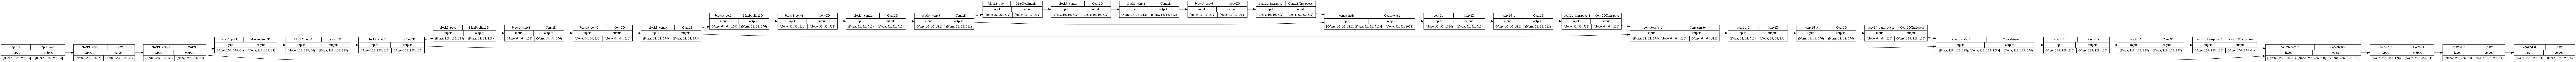

In [11]:
from keras.utils import plot_model

plot_model(model, to_file="../plot_model/vgg16_unet_model.png", rankdir="LR" , show_shapes=True, show_layer_names=True)

In [12]:
tf.keras.backend.clear_session()
# weights = {0: 0.1666, 1: 0.1666, 2: 0.1666, 3: 0.1666, 4: 0.1666, 5: 0.1666}
history = model.fit(X_train, Y_train_cat, batch_size=batch_size, verbose=1, epochs=epochs,
                    validation_data=(X_val, Y_val_cat),
                    callbacks=callbacks)
# history = model.fit(train_gen, batch_size=batch_size, verbose=1, epochs=epochs,
#                     validation_data=val_gen,
#                     callbacks=callbacks)
model.save(model_file)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.0304 - accuracy: 0.3923 - jacard_coef: 0.1917
Epoch 1: val_loss improved from inf to 1.25172, saving model to ../models\vgg16_unet_transfer_learning_model.keras
9/9 [==============================] - 66s 7s/step - loss: 3.0304 - accuracy: 0.3923 - jacard_coef: 0.1917 - val_loss: 1.2517 - val_accuracy: 0.4726 - val_jacard_coef: 0.2716 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.5663 - jacard_coef: 0.3203
Epoch 2: val_loss improved from 1.25172 to 0.84651, saving model to ../models\vgg16_unet_transfer_learning_model.keras
9/9 [==============================] - 62s 7s/step - loss: 1.0238 - accuracy: 0.5663 - jacard_coef: 0.3203 - val_loss: 0.8465 - val_accuracy: 0.6024 - val_jacard_coef: 0.3613 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.7724 - accuracy: 0.6573 - jacard_coef: 0.4092
Epoch 3: val_loss improved from 0.84651 to 0.655

In [13]:
# # Unfreezing all layers in VGG16
# for layer in base_vgg16.layers:
#     layer.trainable = True
# model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
# model.summary()

In [14]:
# history = model.fit(X_train, Y_train_cat, batch_size=batch_size, verbose=1, epochs=epochs,
#                     validation_data=(X_val, Y_val_cat),
#                     callbacks=callbacks)
# # history = model.fit(train_gen, batch_size=batch_size, verbose=1, epochs=epochs,
# #                     validation_data=val_gen,
# #                     callbacks=callbacks)
# model.save(model_file)

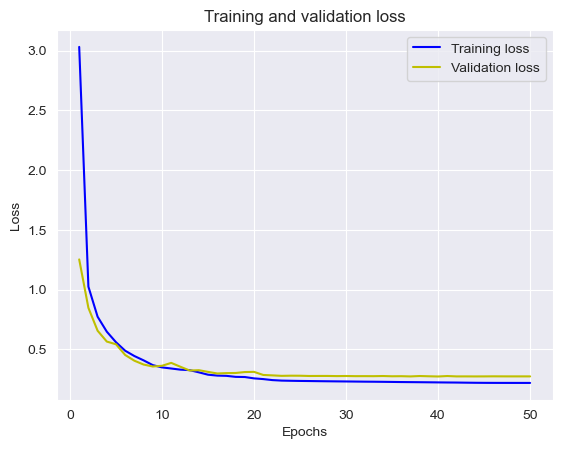

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

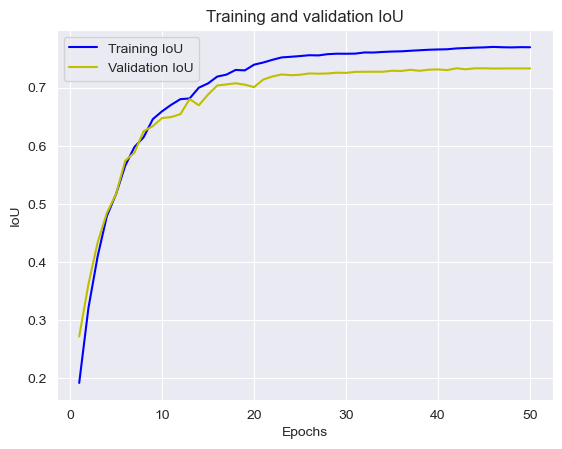

In [16]:
iou = history.history['jacard_coef']
val_iou = history.history['val_jacard_coef']

plt.plot(epochs, iou, 'b', label='Training IoU')
plt.plot(epochs, val_iou, 'y', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [8]:
from keras.models import load_model

model = load_model(model_file,
                   custom_objects={'jacard_coef': jacard_coef})

In [18]:
from keras.metrics import MeanIoU

Y_pred = model.predict(X_test)
# print(Y_pred.shape)
# print(Y_test.shape)
Y_pred_argmax = np.argmax(Y_pred, axis=3)
# Y_test_argmax = np.argmax(Y_test, axis=3)
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test, Y_pred_argmax)
# Accuracy_keras = Accuracy(num_classes=n_classes)
# Accuracy_keras.update_state(Y_test_argmax, Y_pred_argmax)
# print("Accuracy =", Accuracy_keras.result().numpy())
print("Mean IOU =", IOU_keras.result().numpy())

1/1 [==============================] - 5s 5s/step
Mean IOU = 0.6225837


In [19]:
from keras.metrics import Accuracy

Accuracy_keras = Accuracy()
Accuracy_keras.update_state(Y_test, Y_pred_argmax)
print("Test accuracy =", Accuracy_keras.result().numpy())

Test accuracy = 0.8801753


In [20]:
image_directory3 = "../dataset/256_patches_splitted_RF/test/images"
for subdir in os.listdir(image_directory3):
    print("Predict image : " + subdir)
    img = cv2.imread(image_directory3 + "/" + subdir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = preprocess_input(img)
    test_img = np.expand_dims(img, axis=0)
    result = model.predict(test_img)
    segmented_result = np.argmax(result, axis=3)[0, :, :]
    segmented_result = cv2.convertScaleAbs(segmented_result)
    cv2.imwrite('../results/VGG16_UNET/' + subdir, segmented_result)

Predict image : image_patch_11.tif
1/1 [==============================] - 1s 506ms/step
Predict image : image_patch_17.tif
1/1 [==============================] - 0s 302ms/step
Predict image : image_patch_210.tif
1/1 [==============================] - 0s 314ms/step
Predict image : image_patch_311.tif
1/1 [==============================] - 0s 298ms/step
Predict image : image_patch_34.tif
1/1 [==============================] - 0s 308ms/step
Predict image : image_patch_38.tif
1/1 [==============================] - 0s 292ms/step
Predict image : image_patch_41.tif
1/1 [==============================] - 0s 290ms/step
Predict image : image_patch_410.tif
1/1 [==============================] - 0s 292ms/step
Predict image : image_patch_56.tif
1/1 [==============================] - 0s 303ms/step
Predict image : image_patch_61.tif
1/1 [==============================] - 0s 307ms/step
Predict image : image_patch_610.tif
1/1 [==============================] - 0s 309ms/step
Predict image : image_patch_

[0 1 2 3 4 5]


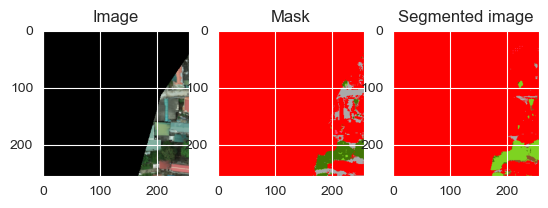

[0 1 2 3 4 5]


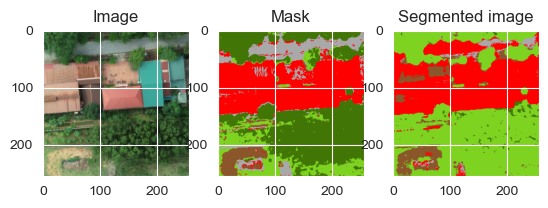

[0 1 2 3 4 5]


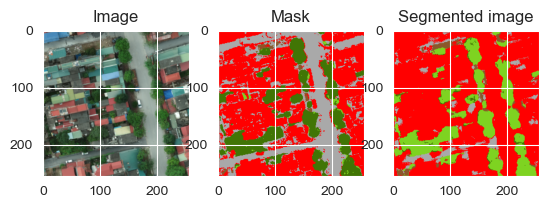

[0 1 2 3 4 5]


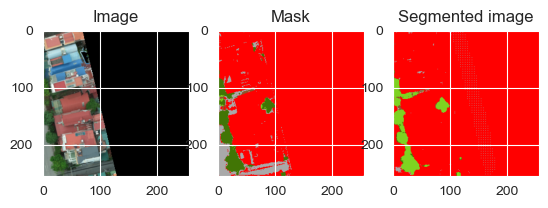

[0 1 2 3 4 5]


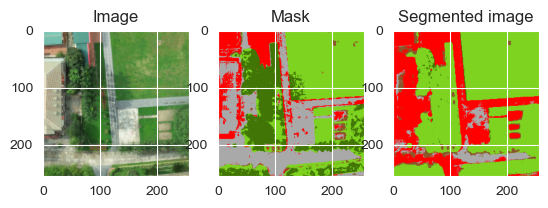

[0 1 2 3 4 5]


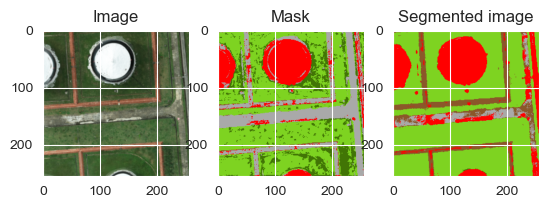

[0 1 2 3 4 5]


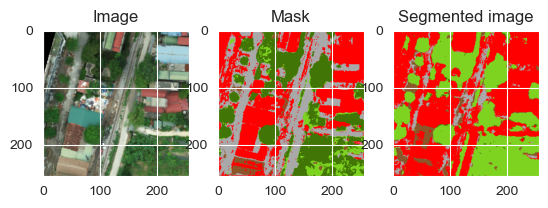

[0 1 2 3 4 5]


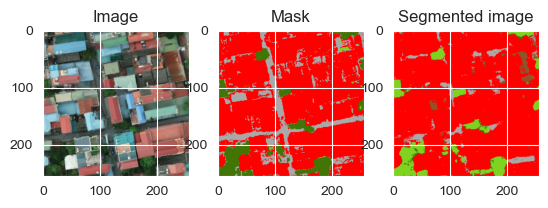

[0 1 2 3 4 5]


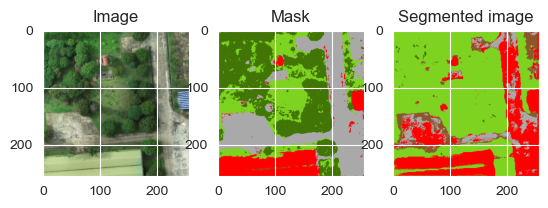

[0 1 2 3 4 5]


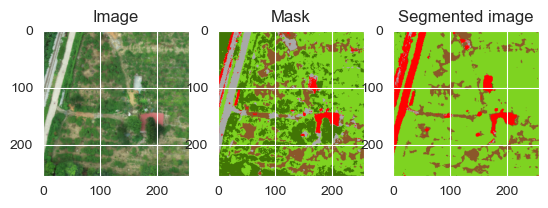

[0 1 2 3 4 5]


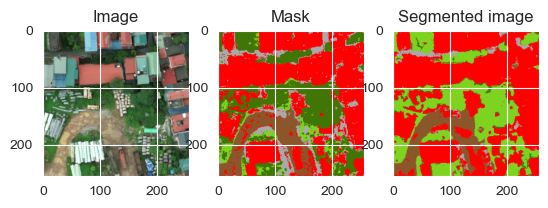

[0 2 3 4 5]


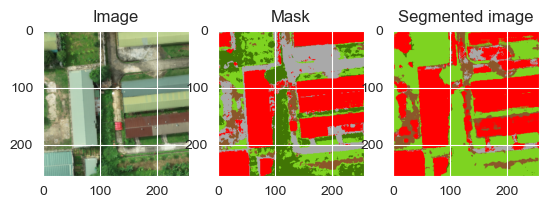

[0 2 3 4 5]


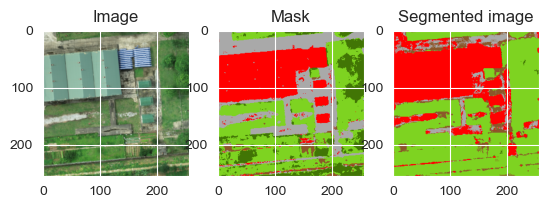

[0 1 2 3 4 5]


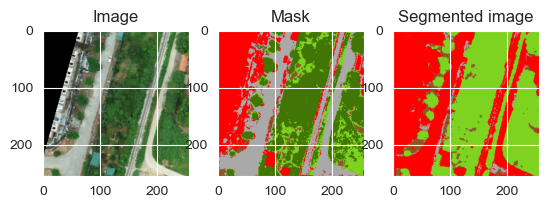

[0 1 2 3 4 5]


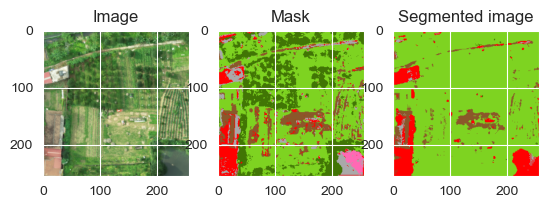

[0 1 2 3 4 5]


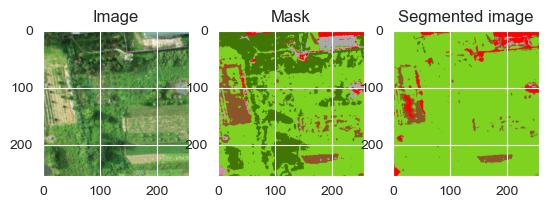

[0 1 2 3 4 5]


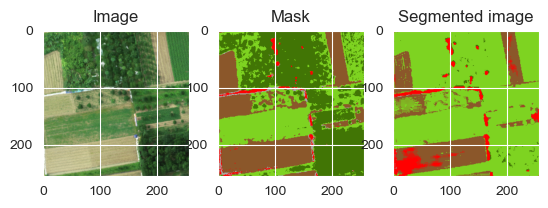

[0 1 2 3 4 5]


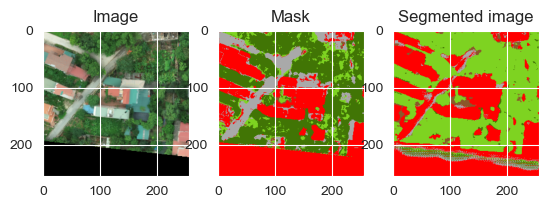

[0 1 2 3 4 5]


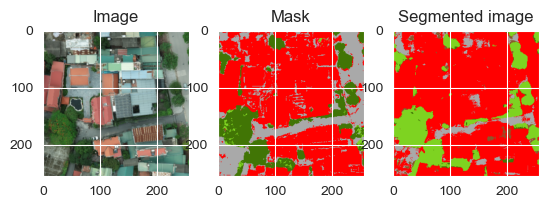

[0 1 2 3 4 5]


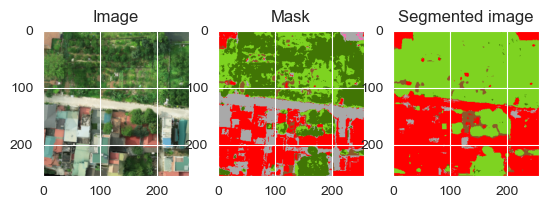

[0 2 3 4 5]


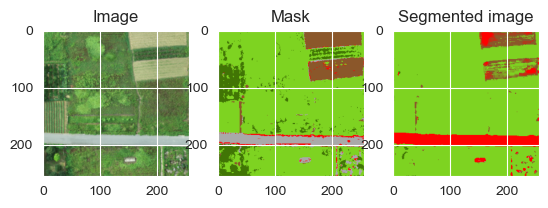

[0 1 2 3 4 5]


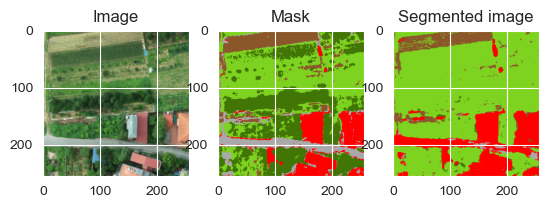

[0 1 2 3 4 5]


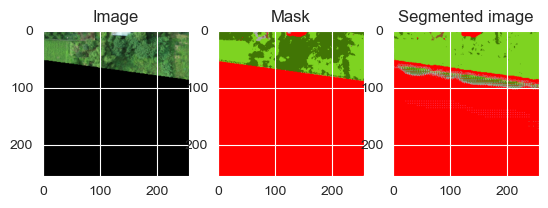

[0 1 2 3 4 5]


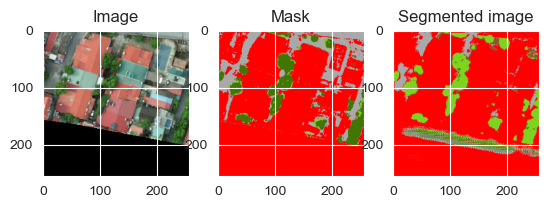

In [21]:
# test_img = cv2.imread("../dataset/256_patches_splitted/train/images/image_patch_15.tif")
# features = feature_extraction(test_img, "image")
# result = loaded_model.predict(features)
# segmented_result = result.reshape((256, 256, 1))
# print("Here  : ", np.unique(segmented_result))
# cv2.imwrite('../results/RF_test_1.tif', segmented_result)
image_directory = "../dataset/256_patches_splitted_RF/test/images"
test_directory = "../dataset/256_patches_splitted_RF/test/masks"
for subdir in os.listdir(test_directory):
    result_dir = "image" + subdir[5:]
    image = cv2.imread(image_directory + "/" + result_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(test_directory + "/" + subdir)
    result = cv2.imread("../results/VGG16_UNET/" + result_dir, 0)
    print(np.unique(result))
    result = cv2.merge([result, result, result])
    rgb_result = np.zeros(result.shape, dtype=np.uint8)
    for i in range(0, 6):
        rgb_result[np.all(result == [i, i, i], axis=-1)] = color_map[i + 1]
    for i in range(0, 7):
        mask[np.all(mask == [i, i, i], axis=-1)] = color_map[i]
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask)
    plt.subplot(1, 3, 3)
    plt.title("Segmented image")
    plt.imshow(rgb_result)
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 115s 6s/step


 12%|█▎        | 1/8 [02:01<14:07, 121.00s/it]

18/18 [==============================] - 114s 6s/step


 25%|██▌       | 2/8 [04:05<12:17, 122.85s/it]

18/18 [==============================] - 115s 6s/step


 38%|███▊      | 3/8 [06:06<10:10, 122.03s/it]

18/18 [==============================] - 112s 6s/step


 50%|█████     | 4/8 [08:04<08:01, 120.45s/it]

18/18 [==============================] - 111s 6s/step


 62%|██████▎   | 5/8 [10:00<05:57, 119.03s/it]

18/18 [==============================] - 109s 6s/step


 75%|███████▌  | 6/8 [11:54<03:54, 117.24s/it]

18/18 [==============================] - 108s 6s/step


 88%|████████▊ | 7/8 [13:48<01:56, 116.33s/it]

18/18 [==============================] - 109s 6s/step


100%|██████████| 8/8 [15:43<00:00, 117.92s/it]


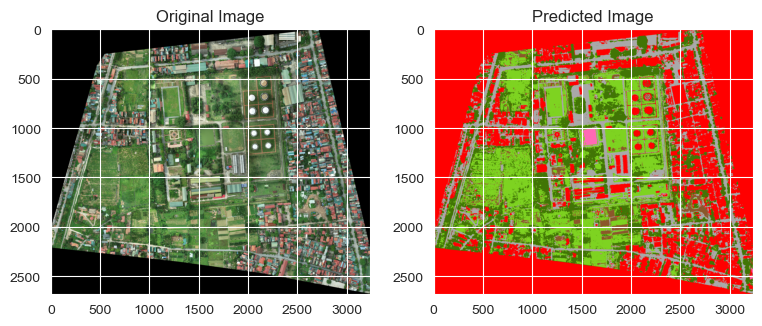

In [12]:
from smooth_blending import predict_img_with_smooth_windowing

patch_size = 256
file_path = "../scenes/01.Khoxang_H6/1_transparent_mosaic_group1_resample_03m.tif"
large_image = cv2.imread(file_path)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
input_img = scaler.fit_transform(large_image.reshape(-1, large_image.shape[-1])).reshape(large_image.shape)
prediction = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)
predicted_image = np.argmax(prediction, axis=2)
predicted_image = cv2.convertScaleAbs(predicted_image)
cv2.imwrite("../results/vgg16_unet.tif", predicted_image)
predicted_image = cv2.merge([predicted_image, predicted_image, predicted_image])
for i in range(0, 6):
    predicted_image[np.all(predicted_image == [i, i, i], axis=-1)] = color_map[i + 1]
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(large_image)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()